# 0 - Imports

In [12]:
import pandas as pd
import json
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv("../data/train.csv") # chargement des données d'entraînement
train_df = train_df.set_index("id")
train_df.entities = train_df.entities.apply(json.loads) # parsing des entités
train_df.relations = train_df.relations.apply(json.loads) # parsing des relations
train_df.head()

,text,entities,relations
id,,,
181,"Anam Destresse, président de l'ONG ""Ma passion...","[{'id': 0, 'mentions': [{'value': 'accident', ...","[[0, STARTED_IN, 9], [7, IS_LOCATED_IN, 9], [5..."
31669,"À Paris, le 8 avril 2022, l'usine de déodorant...","[{'id': 0, 'mentions': [{'value': 'explosé', '...","[[9, IS_LOCATED_IN, 8], [11, OPERATES_IN, 8], ..."
51470,"En Espagne, dans une région agricole, une cont...","[{'id': 0, 'mentions': [{'value': 'contaminati...","[[7, IS_PART_OF, 8], [9, OPERATES_IN, 1], [0, ..."
51332,Un important incendie a fait des ravages dans ...,"[{'id': 0, 'mentions': [{'value': 'incendie', ...","[[12, IS_IN_CONTACT_WITH, 5], [0, IS_LOCATED_I..."
1131,« Je coule » : onze heures après avoir envoyé ...,"[{'id': 0, 'mentions': [{'value': 'renversé', ...","[[9, IS_LOCATED_IN, 2], [0, START_DATE, 17], [..."


In [3]:
text_181_entity_0 = train_df.loc[181].entities[0] # sélection de la première entité listée pour le texte 181
print(text_181_entity_0) # affichage de la description complète de l'entité
print(text_181_entity_0["mentions"][0]) # affichage de la description de la première mention de l'entité
print(text_181_entity_0["mentions"][0]["value"]) # affichage de la valeur de l'entité

{'id': 0, 'mentions': [{'value': 'accident', 'start': 70, 'end': 78}, {'value': 'accident de circulation', 'start': 100, 'end': 123}, {'value': 'accident', 'start': 275, 'end': 283}], 'type': 'ACCIDENT'}
{'value': 'accident', 'start': 70, 'end': 78}
accident


In [4]:
text_181_relation_0 = train_df.loc[181].relations[0] # sélection de la première relation listée pour le texte 181
print(text_181_relation_0) # affichage de la description complète de la relation
print(text_181_relation_0[0]) # affichage de l'entité source de la relation
print(text_181_relation_0[1]) # affichage du type de la relation
print(text_181_relation_0[2]) # affichage de l'entité cible de la relation

[0, 'STARTED_IN', 9]
0
STARTED_IN
9


# 1 - Observation des repartitions

In [23]:
type_count = {}
for x in train_df.entities :
    for y in x : 
        if y["type"] in type_count :
            type_count[y["type"]] += 1
        else :
            type_count[y["type"]] = 1

print(type_count)

{'ACCIDENT': 296, 'CIVILIAN': 1253, 'MATERIEL': 3978, 'GROUP_OF_INDIVIDUALS': 1841, 'NON_GOVERNMENTAL_ORGANISATION': 753, 'PLACE': 2348, 'TERRORIST_OR_CRIMINAL': 70, 'TIME_EXACT': 741, 'FIRSTNAME': 1177, 'LASTNAME': 1157, 'CATEGORY': 886, 'QUANTITY_EXACT': 229, 'CBRN_EVENT': 141, 'NON_MILITARY_GOVERNMENT_ORGANISATION': 619, 'FIRE': 131, 'COLOR': 89, 'QUANTITY_FUZZY': 348, 'POLLUTION': 33, 'MILITARY': 21, 'GATHERING': 208, 'NATURAL_EVENT': 70, 'LENGTH': 19, 'TIME_FUZZY': 273, 'TIME_MIN': 52, 'TIME_MAX': 24, 'QUANTITY_MIN': 44, 'NATIONALITY': 174, 'STRIKE': 33, 'EPIDEMIC': 59, 'HEIGHT': 13, 'WEIGHT': 38, 'BOMBING': 32, 'NATURAL_CAUSES_DEATH': 22, 'THEFT': 67, 'DEMONSTRATION': 36, 'AGITATING_TROUBLE_MAKING': 21, 'MILITARY_ORGANISATION': 45, 'ELECTION': 28, 'SUICIDE': 23, 'CRIMINAL_ARREST': 72, 'WIDTH': 14, 'TRAFFICKING': 30, 'POLITICAL_VIOLENCE': 27, 'MATERIAL_REFERENCE': 33, 'DRUG_OPERATION': 16, 'CIVIL_WAR_OUTBREAK': 17, 'COUP_D_ETAT': 20, 'INTERGOVERNMENTAL_ORGANISATION': 17, 'ECONOMIC

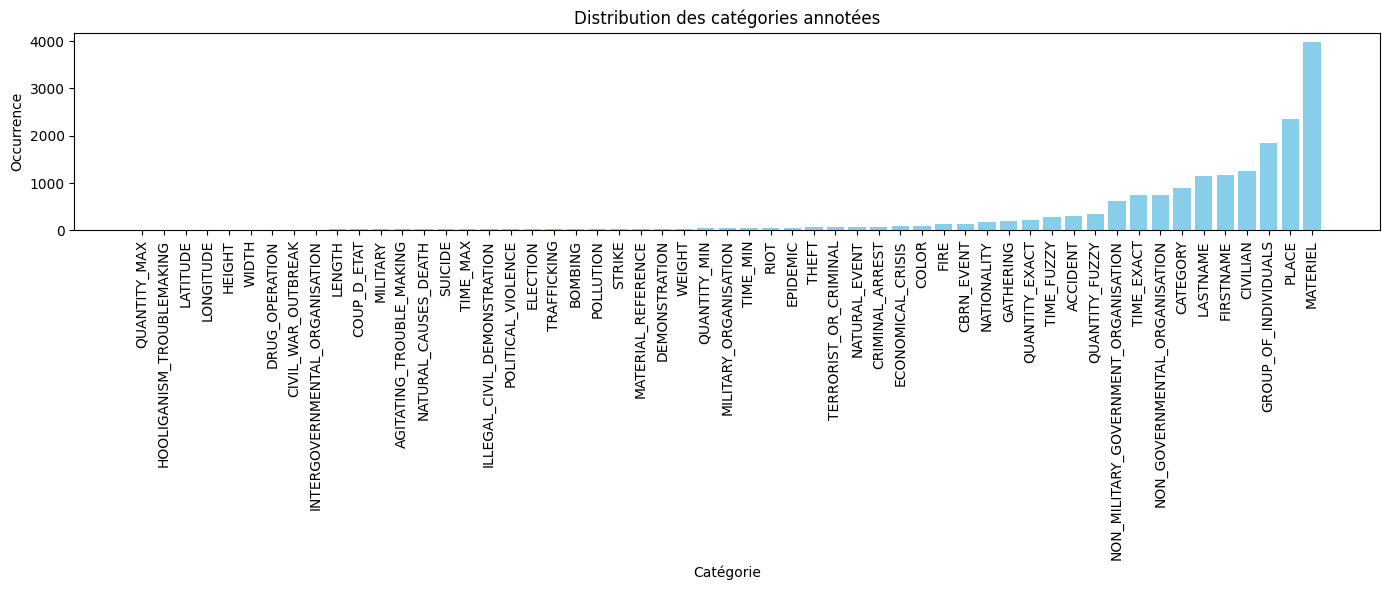

In [ ]:
sorted_type= dict(sorted(type_count.items(), key=lambda item: item[1]))

plt.figure(figsize=(14, 8))
plt.bar(sorted_type.keys(), sorted_type.values(), color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Catégorie')
plt.ylabel('Occurrence')
plt.title('Distribution des catégories annotées')
plt.tight_layout()
plt.show()

#On observe une sacrée disparité...

In [25]:
relations_count = {}
for x in train_df.relations  :
    for y in x : 
        if y[1] in relations_count :
            relations_count[y[1]] += 1
        else :
            relations_count[y[1]] = 1

print(relations_count)

{'STARTED_IN': 1860, 'IS_LOCATED_IN': 9025, 'GENDER_FEMALE': 414, 'HAS_CATEGORY': 894, 'IS_DEAD_ON': 68, 'GENDER_MALE': 908, 'START_DATE': 1034, 'END_DATE': 874, 'IS_OF_SIZE': 438, 'OPERATES_IN': 2435, 'HAS_QUANTITY': 191, 'HAS_COLOR': 91, 'IS_PART_OF': 1462, 'CREATED': 126, 'IS_IN_CONTACT_WITH': 2919, 'HAS_CONTROL_OVER': 4547, 'IS_COOPERATING_WITH': 372, 'INITIATED': 469, 'HAS_FOR_LENGTH': 16, 'HAS_CONSEQUENCE': 769, 'WAS_CREATED_IN': 15, 'IS_OF_NATIONALITY': 179, 'IS_AT_ODDS_WITH': 1526, 'HAS_FOR_HEIGHT': 12, 'RESIDES_IN': 222, 'WEIGHS': 41, 'IS_BORN_ON': 20, 'IS_BORN_IN': 50, 'INJURED_NUMBER': 70, 'HAS_FAMILY_RELATIONSHIP': 222, 'HAS_FOR_WIDTH': 14, 'IS_REGISTERED_AS': 34, 'DEATHS_NUMBER': 75, 'WAS_DISSOLVED_IN': 14, 'HAS_LONGITUDE': 12, 'HAS_LATITUDE': 10, 'DIED_IN': 41}


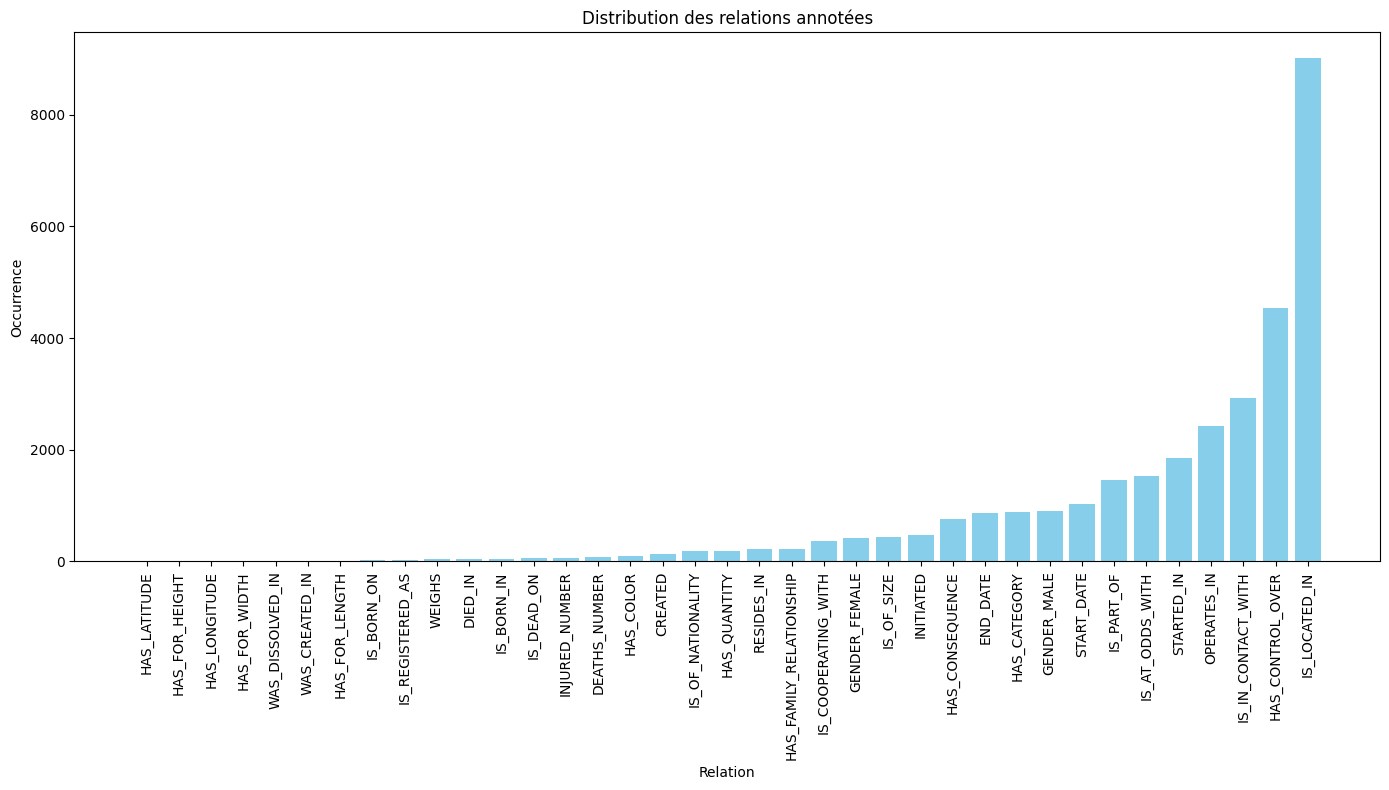

In [26]:
sorted_relations = dict(sorted(relations_count.items(), key=lambda item: item[1]))

plt.figure(figsize=(14, 8))
plt.bar(sorted_relations.keys(), sorted_relations.values(), color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Relation')
plt.ylabel('Occurrence')
plt.title('Distribution des relations annotées')
plt.tight_layout()
plt.show()

#On observe encore une sacrée disparité... Cela risque de poser des soucis à l'entrainement.